In [1]:
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import random
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import kurtosis, skew, iqr, norm, t, laplace, beta, multivariate_normal
from collections import Counter
np.set_printoptions(suppress=True)

# 1)Сформувати тестову вибірку зображень з вихідного пакету - 250 зображень
(Формування вибірки зображень – псевдовипадкове, з використанням генератора Мерсена (стартове значення співпадає з номером студента в загальному списку групи) за модулем кількості зображень в тестовому пакеті.)

In [2]:
IMAGE_COUNT = 250
NICCKY_NUMBER = 8
FULL_IMAGES_COUNT = len(os.listdir('mirflickr'))

In [4]:
images = []

while len(images) != IMAGE_COUNT:
    randIndex = random.randint(NICCKY_NUMBER, FULL_IMAGES_COUNT)
    image_name = 'im{index}.jpg'.format(index = randIndex)
    image = cv2.imread(glob.glob('./mirflickr/{}'.format(image_name))[0])[:, :, 1]
    #images.append((image_name, image))
    images.append(image)
    
images = np.asarray(images)

# 2)	Для зеленого каналу кольору тестових зображень обчислити наступні характеристики розподілу значень яскравості пікселів:
### a)	Математичне очікування та дисперсію;
### b)	Медіану та інтерквартильний розмах;
### c)	Коефіцієнти асиметрії та ексцесу (нормалізований);
### d)	Гістограму значень яскравості пікселів (нормалізовану);


In [5]:
def mathExp(image):
    return np.mean(image)

In [6]:
def variance(image):
    return np.var(image)

In [7]:
def median(image):
    return np.median(image)

In [8]:
def interQ(image):
    return iqr(image.reshape(-1))

In [9]:
#Ексцес
def calcKurtosis(image):
    return kurtosis(image.reshape(-1))

In [10]:
#Асиметрія
def calcSkew(image):
    return skew(image.reshape(-1))

In [11]:
def plotHist(image, dist):
    _, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True);
    plt.figure(figsize=(10, 5));
    sns.distplot(image.reshape(-1), kde=False, ax=axes[0]);
    if dist == 't':
        sns.distplot(image.reshape(-1), fit=t, kde=False, ax=axes[1]);
    elif dist == 'beta':
        sns.distplot(image.reshape(-1), fit=beta, kde=False, ax=axes[1]);
    elif dist == 'laplace':
        sns.distplot(image.reshape(-1), fit=laplace, kde=False, ax=axes[1]);
    elif dist == 'norm':
        sns.distplot(image.reshape(-1), fit=norm, kde=False, ax=axes[1]);
    plt.show();

In [12]:
def count_statistics(img, normalized = False):
    math_exp_ = np.mean(img)
    variance_ = np.var(img)
    median_ = np.median(img)
    IQR_ = iqr(img.reshape(-1))
    if normalized:
        img = img / 255.
    kurtosis_ = kurtosis(img.reshape(-1))
    skew_ = skew(img.reshape(-1))
    return math_exp_, variance_, median_, IQR_, kurtosis_, skew_

/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


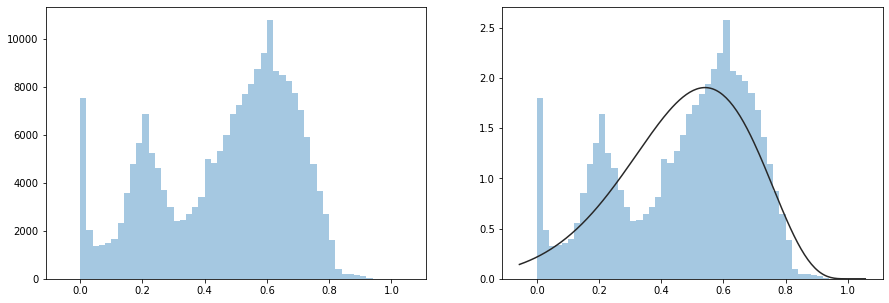

<Figure size 720x360 with 0 Axes>

In [13]:
plotHist(images[3] / 255., 'beta');

# 3)	Провести обробку отриманих гістограм: 
### a)	Провести апроксимацію гістограм з використанням імовірнісних розподілів:
#### i)	Нормального (гаусового) розподілу;
#### ii)	Розподілу Лапласа;
#### iii)	Розподілу Стьюдента;
#### iv)	Бета розподілу;
### b)	Для кожної гістограми визначити найкращий тип апроксимуючого розподілу за критерієм мінімізації середньо квадратичного відхилення;
### c)	Побудувати розподіл отриманих апроксимацій за видом апроксимуючого розподілу;


In [19]:
def approxHist(image):
    image = image.reshape(-1)
    space = np.linspace(0,255,num=256)
    minSse = 10**100
    distribution = None
    arr = []
    for i in range(256):
        arr.append(Counter(image)[i])
    for dist in [norm,laplace,t,beta]:
        params = dist.fit(image)
        
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]
        
        pdf = dist.pdf(space,loc=loc,scale=scale,*arg)
        
        sse = np.sum(np.power(arr - pdf, 2.0))
        
        if sse < minSse:
            minSse = sse
            distribution = dist
    return distribution, minSse, str(distribution).split('.')[3].split(' ')[0].split('_')[0]    

math exp: 129.19332905982907
var: 393.8064657549674
median: 129.0
coefKurtosis: 4.274011141796672
coefSkew: -0.604307681005208


/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


t
distribution: t
squared error: 1017717352.0535064


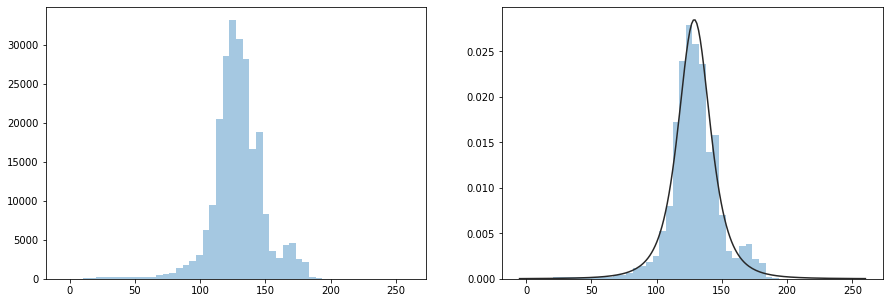

<Figure size 720x360 with 0 Axes>

math exp: 153.12436898395723
var: 3680.325650002889
median: 166.0
coefKurtosis: 0.6257169873323596
coefSkew: -1.142494060662575
beta
distribution: beta
squared error: 239128470.57420012


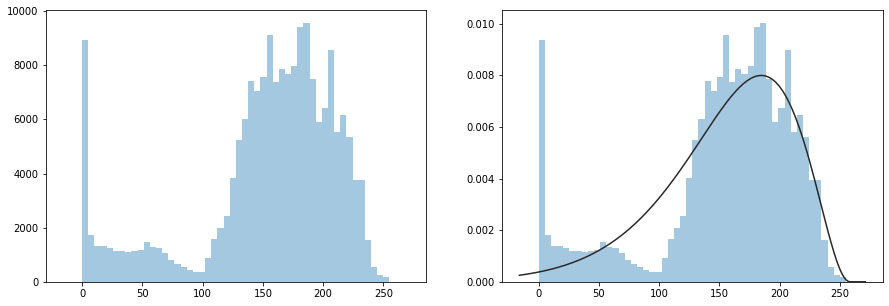

<Figure size 720x360 with 0 Axes>

math exp: 106.00854612546125
var: 10093.83845094898
median: 70.0
coefKurtosis: -1.3912861479100822
coefSkew: 0.4837269777990725
laplace
distribution: laplace
squared error: 1809398560.0363848


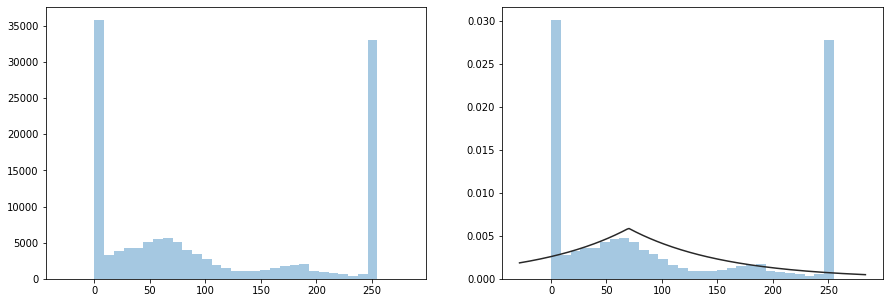

<Figure size 720x360 with 0 Axes>

In [15]:
for index in [100,101,102]:
    image = images[index]
    mathEx = mathExp(image)
    var = variance(image)
    med = median(image)
    coefKurtosis = calcKurtosis(image)
    coefSkew = calcSkew(image)
    print('math exp: {}'.format(mathEx))
    print('var: {}'.format(var))
    print('median: {}'.format(med))
    print('coefKurtosis: {}'.format(coefKurtosis))
    print('coefSkew: {}'.format(coefSkew))
    _, sse, distName = approxHist(image)
    print('distribution: {}'.format(distName))
    print('squared error: {}'.format(sse))
    plotHist(image,distName)

In [17]:
import sys


def progress(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush()

In [20]:
distList = []
N = len(images)
for i, image in enumerate(images):
    _, _, distr = approxHist(image)
    distList.append(distr)
    progress(i,N)

/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


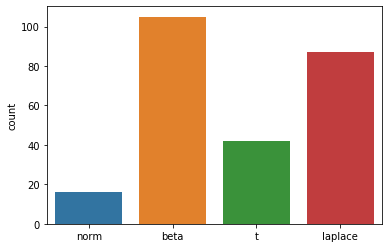

In [21]:
import seaborn as sns
sns.countplot(distList)

In [22]:
mathExpArr = []
varArr = []
skewArr = []
kurtArr = []
iqrArr = []
medianArr = [] 
for image in images:
    mathExpArr.append(mathExp(image))
    varArr.append(variance(image))
    kurtArr.append(calcKurtosis(image))
    skewArr.append(calcSkew(image))
    iqrArr.append(interQ(image))
    medianArr.append(median(image))

In [23]:
print(np.mean(mathExpArr))
print(np.mean(varArr))
print(np.mean(skewArr))
print(np.mean(kurtArr))
print(np.mean(iqrArr))
print(np.mean(medianArr))

104.73577091505727
4123.892530385558
0.32995442402957204
0.5951623295275801
92.136
98.772


# 4)	Побудувати багатовимірні гаусові моделі:

#### i)	Математичне очікування;

Mean vec: 104.67955794606016
Cov matrix: 1627.5391818813937


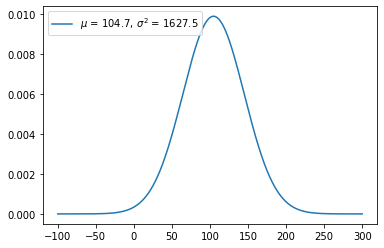

In [17]:
meanVec1 = np.mean(mathExpArr)
covMatrix1 = np.cov(mathExpArr)
print('Mean vec: {}'.format(meanVec1))
print('Cov matrix: {}'.format(covMatrix1))

x = np.linspace(start = -100, stop = 300, num = 2000)
y = norm(meanVec1, np.sqrt(covMatrix1)).pdf(x)
plt.plot(x, y, label = '$\mu$ = {}, $\sigma^2$ = {}'.format(np.round(meanVec1, 1), np.round(covMatrix1, 1)))
plt.legend();

#### ii)	Математичне очікування та дисперсія;

In [18]:
arr = np.vstack((mathExpArr,varArr))
meanVec2 = np.mean(arr, axis=1)
covMatrix2 = np.cov(arr)
print('Mean vec: ', *meanVec2)
print('Cov matrix: ', covMatrix2)

Mean vec:  104.67955794606016 4383.115496901823
Cov matrix:  [[   1627.53918188   21343.13949954]
 [  21343.13949954 5013292.42085961]]


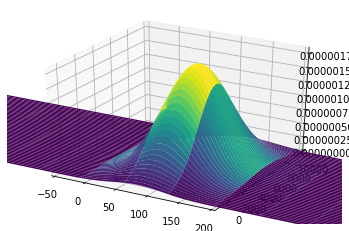

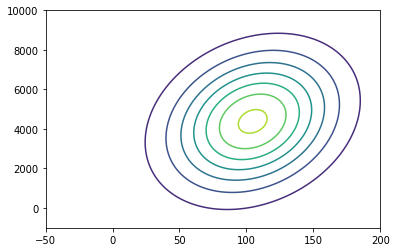

In [19]:
x, y = np.mgrid[-500:3000, -1000:10000]
position = np.empty(x.shape + (2,))
position[:, :, 0] = x
position[:, :, 1] = y
z = multivariate_normal(meanVec2, covMatrix2).pdf(position)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlim(-50, 200)
ax.set_ylim(-1000, 10000)
ax.plot_surface(x, y, z, cmap='viridis')
plt.show()

plt.xlim(-50, 200)
plt.ylim(-1000, 10000)
plt.contour(x, y, z)
plt.show()

#### iii)	Математичне очікування, дисперсія та коефіцієнт асиметрії;

In [20]:
arr = np.vstack((mathExpArr, varArr, skewArr))
meanVec3 = np.mean(arr, axis=1)
covMatrix3 = np.cov(arr)
print('mean_vec: ', *meanVec3)
print('cov_matrix: \n', covMatrix3)

mean_vec:  104.67955794606016 4383.115496901823 0.41686893020574406
cov_matrix: 
 [[   1627.53918188   21343.13949954     -37.87617552]
 [  21343.13949954 5013292.42085961    -481.18713657]
 [    -37.87617552    -481.18713657       1.26675952]]


#### iv)	Математичне очікування, дисперсія, коефіцієнти асиметрії та ексцесу;

In [21]:
arr = np.vstack((mathExpArr, varArr, skewArr, kurtArr))
meanVec4 = np.mean(arr, axis=1)
covMatrix4 = np.cov(arr)
print('mean_vec: ', *meanVec4)
print('cov_matrix: \n', covMatrix4)

mean_vec:  104.67955794606016 4383.115496901823 0.41686893020574406 0.6880502125454411
cov_matrix: 
 [[   1627.53918188   21343.13949954     -37.87617552     -87.33030698]
 [  21343.13949954 5013292.42085961    -481.18713657   -4687.32779402]
 [    -37.87617552    -481.18713657       1.26675952       4.91767249]
 [    -87.33030698   -4687.32779402       4.91767249      42.6541311 ]]


Отже, з усього пакету картинок було відібрано 250 картинок обрахували для зеленого кольору Математичне очікування та дисперсію, Медіану та інтерквартильний розмах;	Коефіцієнти асиметрії та ексцесу (нормалізований); побудовано Гістограму значень яскравості пікселів (нормалізовану);Провели апроксимацію гістограм з використанням ймовірносних розподілів. Та побудували багатовимірні Гаусові моделі. 
